# Advance Summarization Using Map-Reduce Method

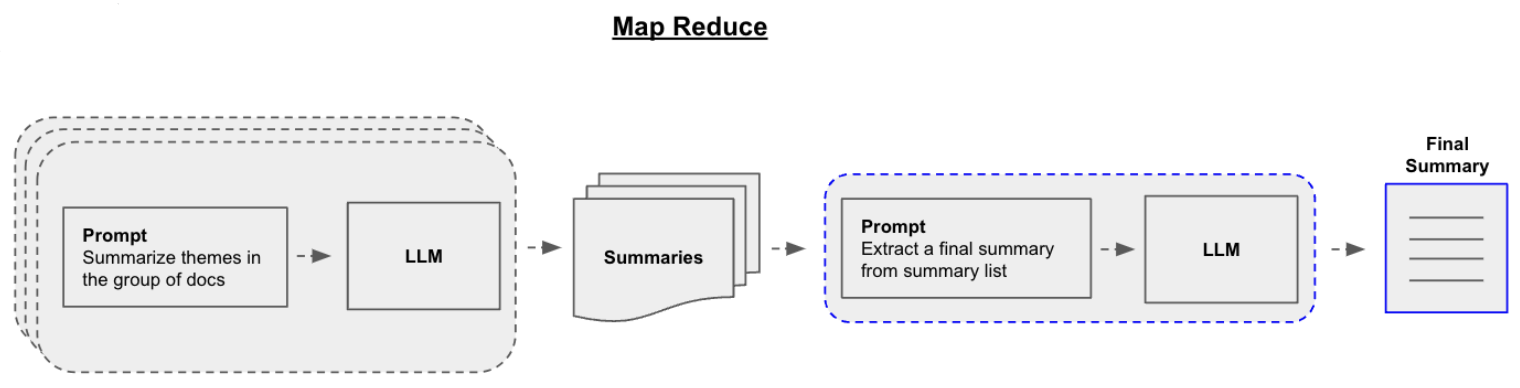

We suppose that we have a set of documents and we want to summarize the content. LLMs are great tool for this given their proficiency in understanding and synthesizing text.

In this notebook, we'll use a advance method called map-reduce which breaks questions into smaller pieces, summarizes each one, and then combines the results. For this, we’ll first map each document to an individual summary using an `LLMChai`. Then we’ll use a `ReduceDocumentsChain` to combine those summaries into a single global summary.

In [1]:
# First load document use into 2 methods
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/")
docs = loader.load()

/Users/ktuna/projects/github_repos/simple_langchain_applications/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Easy method, it is available for the both by using 'load_summarize_chain' function 
from langchain.chains.summarize import load_summarize_chain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model_name="gpt-4-1106-preview")
# We can also supply chain_type="map_reduce" or chain_type="refine".
chain = load_summarize_chain(llm, chain_type="map_reduce")

chain.run(docs)

/Users/ktuna/projects/github_repos/simple_langchain_applications/env/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


'The blog post "The Transformer Family Version 2.0" by Lilian Weng is an updated overview of the developments in Transformer architectures since 2020. It covers the fundamentals of Transformers, various attention mechanisms, and positional encoding methods. The post explores strategies for managing longer sequences and introduces adaptive and efficient attention techniques. It also examines the use of Transformers in reinforcement learning and provides a structured guide with detailed explanations, mathematical notations, and figures, making it a valuable resource for those interested in the progression of Transformer models in natural language processing and related fields.'

In [3]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-0125")

# Map
map_template = """The following is a set of documents
{docs}
Based on this list of docs, please identify the main themes 
Helpful Answer:"""
map_prompt = PromptTemplate.from_template(map_template)
# Run Chain
map_chain = LLMChain(llm=llm, prompt=map_prompt)

/Users/ktuna/projects/github_repos/simple_langchain_applications/env/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


**❗️Note:** The `ReduceDocumentsChain` handles taking the document mapping results and reducing them into a single output. It wraps a generic `CombineDocumentsChain` (like `StuffDocumentsChain`) but adds the ability to collapse documents before passing it to the `CombineDocumentsChain` if their cumulative size exceeds `token_max`. In this example, we can actually re-use our chain for combining our docs to also collapse our docs.

So if the cumulative number of tokens in our mapped documents exceeds 4000 tokens, then we’ll recursively pass in the documents in batches of \< 4000 tokens to  `StuffDocumentsChain` function to create batched summaries. And once those batched summaries are cumulatively less than 4000 tokens, we’ll pass them all one last time to the `StuffDocumentsChain` to create the final summary.

In [4]:
# Reduce
reduce_template = """The following is set of summaries:
{docs}
Take these and distill it into a final, consolidated summary of the main themes. 
Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)
# Run Chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

In [5]:
# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)

Combining map and reduce chains into one

In [6]:
# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)

Created a chunk of size 1121, which is longer than the specified 1000


In [7]:
print(map_reduce_chain.run(split_docs))

The main themes identified across the provided documents include various aspects of Transformer models, attention mechanisms in neural networks, efficient and adaptive transformer architectures, long-range sequence modeling, reinforcement learning applications of transformers, and positional embeddings in transformer models. These themes collectively highlight the advancements and innovations in machine learning, artificial intelligence, and language modeling, emphasizing the importance of optimizing model efficiency, handling long-context sequences, and exploring new approaches to enhance performance in various tasks.
